<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/Trabajo_Uriel_Aprendizaje_produndo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from  google.colab import drive
 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
train_path = '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training'
val_path   = '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/validation'
test_path   = '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/evaluation'

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 

# Keras
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
#Creamos listas con todos los nombres de los ficheros 
train = [os.path.join(train_path,img) for img in os.listdir(train_path)]
val   = [os.path.join(val_path,img) for img in os.listdir(val_path)]
test   = [os.path.join(val_path,img) for img in os.listdir(val_path)]


len(train),len(val),len(test)

(300, 90, 90)

In [7]:
train[0:3]

['/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training/1_33.jpg',
 '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training/1_74.jpg',
 '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training/1_24.jpg']

In [8]:
#Troceamos por la ultima '/' y por '_' para quedarnos el primer numero y lo pasamos a entero
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 3

#One hot encoding para tener las etiquetas
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

In [9]:
#Vemos lo que obtenemos con el 'one hot'
print(train_y[0:20])
print(y_train[0:20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


Datos de entrenamiento en:  3 clases
[100, 100, 100]


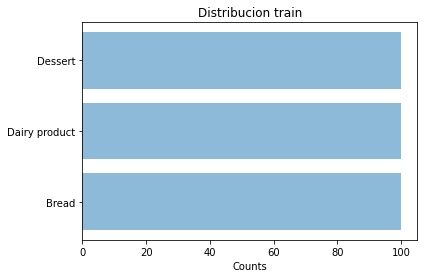

In [10]:
print("Datos de entrenamiento en: ", num_classes, "clases")
print([train_y.count(i) for i in range(num_classes)])
 
food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat', 'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
food_classes = food_classes[0:num_classes]
 
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(num_classes)]
 
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Distribucion train')
 
plt.show()

In [11]:
print("Datos de validacion en: ", num_classes, "clases")
print([val_y.count(i) for i in range(num_classes)])
print("Datos de test en: ", num_classes, "clases")
print([test_y.count(i) for i in range(num_classes)])

Datos de validacion en:  3 clases
[30, 30, 30]
Datos de test en:  3 clases
[30, 30, 30]


In [12]:
#Clase para mostrar imagenes
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            ax = plt.subplot2grid((4,4),(i,j))  
            ax.set_title('Clase: ' + str(train_y[k]) )     
            plt.imshow(image)            
            k = k+1
    #Muestra
    plt.show()

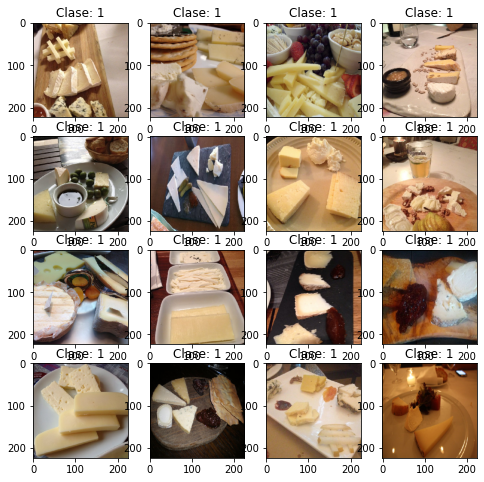

In [13]:
show_imgs(train)

In [14]:
def create_features(dataset):
 
    x_scratch = []

    k=0

    #Bucle sobre las imagenes
    for imagePath in dataset:
 
        #Se cargan las imagenes a tamaño 224
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)

        k = k+1
        print('convertida:', k, ' de ', len(dataset))
 
    x = np.vstack(x_scratch)
    return x

In [15]:
train_x = create_features(train)
val_x = create_features(val)
test_x = create_features(test)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

convertida: 1  de  300
convertida: 2  de  300
convertida: 3  de  300
convertida: 4  de  300
convertida: 5  de  300
convertida: 6  de  300
convertida: 7  de  300
convertida: 8  de  300
convertida: 9  de  300
convertida: 10  de  300
convertida: 11  de  300
convertida: 12  de  300
convertida: 13  de  300
convertida: 14  de  300
convertida: 15  de  300
convertida: 16  de  300
convertida: 17  de  300
convertida: 18  de  300
convertida: 19  de  300
convertida: 20  de  300
convertida: 21  de  300
convertida: 22  de  300
convertida: 23  de  300
convertida: 24  de  300
convertida: 25  de  300
convertida: 26  de  300
convertida: 27  de  300
convertida: 28  de  300
convertida: 29  de  300
convertida: 30  de  300
convertida: 31  de  300
convertida: 32  de  300
convertida: 33  de  300
convertida: 34  de  300
convertida: 35  de  300
convertida: 36  de  300
convertida: 37  de  300
convertida: 38  de  300
convertida: 39  de  300
convertida: 40  de  300
convertida: 41  de  300
convertida: 42  de  300
c

In [16]:
# Creating a checkpointer
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5',
                               verbose=1,save_best_only=True)
# load the VGG16 network
print("[INFO loading network...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_vgg.summary()

[INFO loading network...
58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                     

In [17]:
model_transfer_full = Sequential()
model_transfer_full.add(model_vgg)
model_transfer_full.add(GlobalAveragePooling2D())
model_transfer_full.add(Dropout(0.2))
model_transfer_full.add(Dense(100, activation='relu'))
model_transfer_full.add(Dense(num_classes, activation='softmax'))
model_transfer_full.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 14,766,291
Trainable params: 14,766,291
Non-trainable params: 0
____________________________________________

In [18]:
opt = Adam(learning_rate=0.00001)
model_transfer_full.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_transfer_full.fit(train_x, y_train, batch_size=32, epochs=3,
          validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 3.9321 - accuracy: 0.3933
Epoch 1: val_loss improved from inf to 1.78637, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 27s 1s/step - loss: 3.9321 - accuracy: 0.3933 - val_loss: 1.7864 - val_accuracy: 0.4667
Epoch 2/3
10/10 [==============================] - ETA: 0s - loss: 1.1521 - accuracy: 0.5500
Epoch 2: val_loss improved from 1.78637 to 1.05371, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 5s 477ms/step - loss: 1.1521 - accuracy: 0.5500 - val_loss: 1.0537 - val_accuracy: 0.4889
Epoch 3/3
10/10 [==============================] - ETA: 0s - loss: 0.7854 - accuracy: 0.6333
Epoch 3: val_loss improved from 1.05371 to 0.86863, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 5s 479ms/step - loss: 0.7854 - accuracy: 0.6333 - val_loss: 0.8686 - val_accuracy: 0.5667
